In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf

In [57]:
# ---------- Color: ITMOviolet (LaTeX: \definecolor{ITMOviolet}{RGB}{126,16,255}) ----------
ITMO_VIOLET = (126/255, 16/255, 1.0, 1.0)  # RGBA for Matplotlib (opaque)
# If you prefer transparency, e.g. 60%:
ITMO_VIOLET_60 = (126/255, 16/255, 1.0, 0.6)

ITMO_yellow = ( 1., 1., 0, 1. )
ITMO_green = ( 91/255, 1.0, 0., 1. ) 
ITMO_capri = ( 0., 204/255, 1., 1. )
ITMO_pink = ( 251/255, 118/255, 251/255, 1. )
ITMO_red = ( 249/255,63/255,65/255, 1. )

# Extra
# COLOR = (0/255, 191/255, 255/255, 0.6)  # cyan with 60% opacity

# Make an output folder
os.makedirs("figs", exist_ok=True)

# GBM Model for European Option Pricing

In [35]:
# --- Parameters ---
S0 = 100   # Initial stock price
K = 100    # Strike price
r = 0.05   # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0    # Time to maturity (years)
N = 1000   # Number of time steps

# For reproducibility (so the slide looks the same each time)
rng = np.random.default_rng(33)

# --- Time grid ---
t = np.linspace(0, T, N)
dt = T / (N - 1)  # N points -> N-1 intervals

# --- GBM sample path (exact discrete-time step) ---
# dW ~ N(0, dt)
dW = rng.normal(0.0, np.sqrt(dt), size=N-1)
S = np.empty(N)
S[0] = S0
for i in range(1, N):
    S[i] = S[i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW[i-1])

final_S = S[-1]
final_payoff = max(final_S - K, 0.0)

print(f" Final Stock price {final_S} ")
print(f" Final Payoff value {final_payoff} ")

# --- Payoff curve ---
S_range = np.linspace(0.5 * S0, 1.5 * S0, 600)
payoff = np.maximum(S_range - K, 0.0)
print(f"Average Payoff: {np.mean(payoff)}")

 Final Stock price 109.08759786106586 
 Final Payoff value 9.08759786106586 
Average Payoff: 12.520868113522537


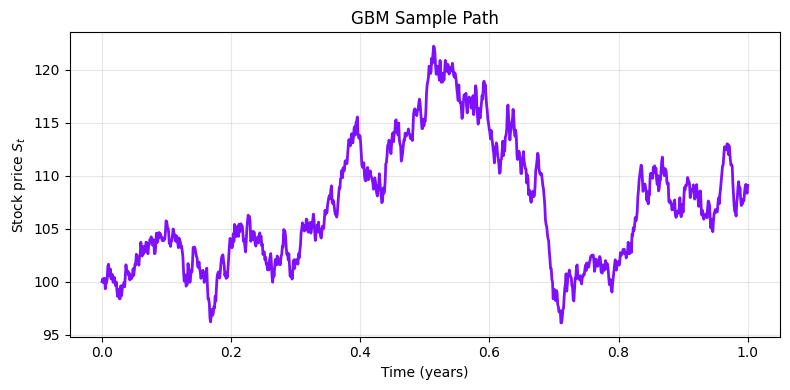

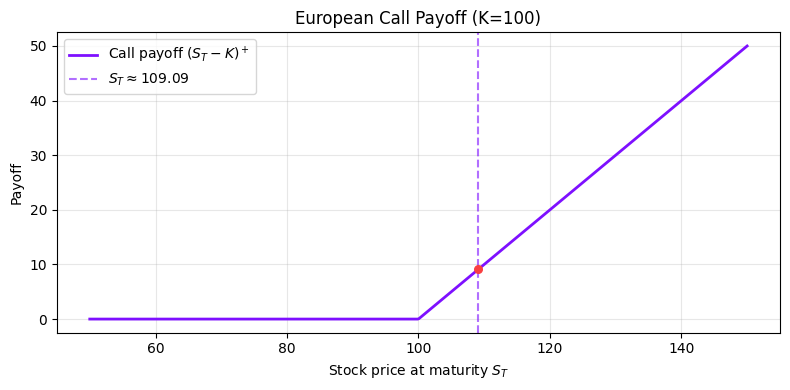

In [50]:
# =========================
# Figure 1: GBM sample path
# =========================
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(t, S, color=ITMO_VIOLET, linewidth=2.0)
ax1.set_title("GBM Sample Path")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel("Stock price $S_t$")
ax1.grid(True, alpha=0.3)
fig1.tight_layout()
fig1.savefig("figs/gbm_path_violet.pdf")
fig1.savefig("figs/gbm_path_violet.png", dpi=300)

# ===========================================
# Figure 2: European call payoff at maturity T
# ===========================================
fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(S_range, payoff, color=ITMO_VIOLET, linewidth=2.0, label="Call payoff $(S_T - K)^+$")
ax2.axvline(final_S, color=ITMO_VIOLET_60, linewidth=1.5, linestyle="--", label=f"$S_T \\approx {final_S:.2f}$")
ax2.scatter([final_S], [final_payoff], color=ITMO_red, s=30, zorder=3)
ax2.set_title(f"European Call Payoff (K={K})")
ax2.set_xlabel("Stock price at maturity $S_T$")
ax2.set_ylabel("Payoff")
ax2.grid(True, alpha=0.3)
ax2.legend()
fig2.tight_layout()
fig2.savefig("figs/call_payoff_violet.pdf")
fig2.savefig("figs/call_payoff_violet.png", dpi=300)

plt.show()


# Real world volatility Clustering and Fat-tails

In [39]:
# --------------------
# 1) Download prices & compute returns
# --------------------
TICKER = "SPY"  # you can switch to "^FTSE" or "^GSPC"
START  = "2005-01-01"

data = yf.download(TICKER, start=START, progress=False, auto_adjust=True)
data = data.dropna()
r = np.log(data["Close"]).diff().dropna()  # daily log-returns

print(f"{TICKER}: {len(r)} daily returns from {r.index.min().date()} to {r.index.max().date()}")
# mu = float(r.mean())
# sd = float(r.std(ddof=1))  # sample std; use ddof=0 for population
# kurt = float(stats.kurtosis(r.to_numpy(), fisher=False, nan_policy="omit"))
# print(f"Mean={mu:.6f}, Std={sd:.6f}, Kurtosis(Pearson)={kurt:.2f}") #urtosis(Pearson)={stats.kurtosis(r, fisher=False)

SPY: 5200 daily returns from 2005-01-04 to 2025-09-04


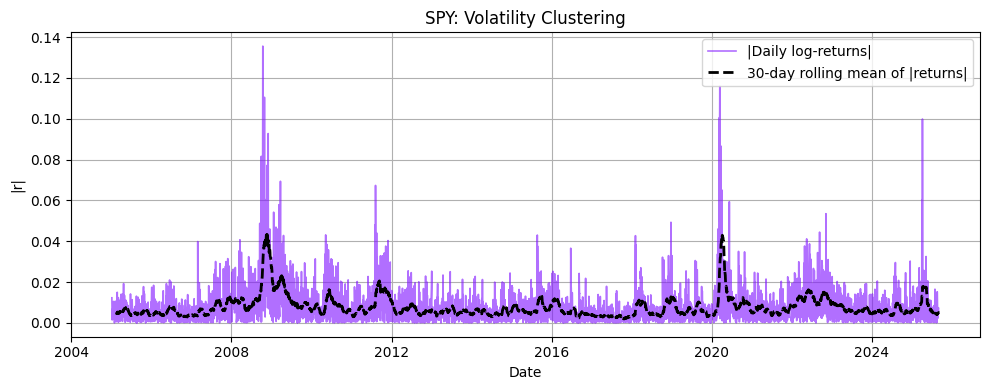

In [43]:
# --------------------
# 2) Volatility clustering (abs returns + rolling mean)
# --------------------
abs_r = r.abs()
roll = abs_r.rolling(30, min_periods=30).mean()

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(abs_r.index, abs_r.values, color=ITMO_VIOLET_60, linewidth=1.2, label="|Daily log-returns|")
ax.plot(roll.index, roll.values, color="black", linewidth=2.0, linestyle="--", label="30-day rolling mean of |returns|")

ax.set_title(f"{TICKER}: Volatility Clustering")
ax.set_ylabel("|r|")
ax.set_xlabel("Date")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig("figs/vol_clustering.pdf")
fig.savefig("figs/vol_clustering.png", dpi=200)

Jarque–Bera: stat=46318.45, p-value=0.000e+00


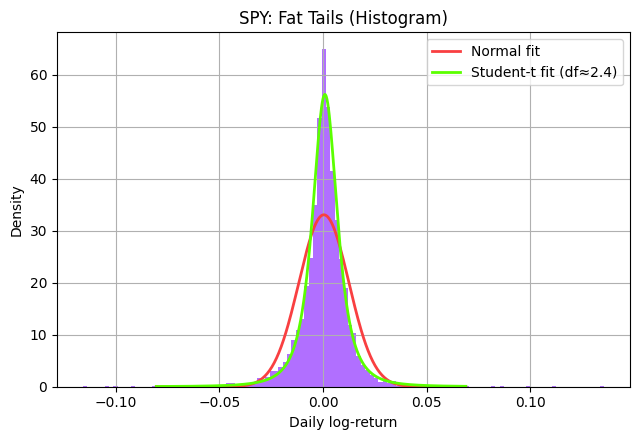

In [58]:
# --------------------
# 3) Fat tails: histogram vs Normal & Student-t fit
# --------------------
mu, sd = r.mean(), r.std()
# Fit a Student-t to returns
df_t, loc_t, scale_t = stats.t.fit(r.values)

xs = np.linspace(r.quantile(0.001), r.quantile(0.999), 400)
pdf_norm = stats.norm.pdf(xs, mu, sd)
pdf_t    = stats.t.pdf(xs, df_t, loc_t, scale_t)

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.hist(r.values, bins=120, color=ITMO_VIOLET_60, density=True, alpha=0.6)
ax.plot(xs, pdf_norm, color=ITMO_red, label="Normal fit", linewidth=2)
ax.plot(xs, pdf_t, color=ITMO_green, label=f"Student-t fit (df≈{df_t:.1f})", linewidth=2)

ax.set_title(f"{TICKER}: Fat Tails (Histogram)")
ax.set_xlabel("Daily log-return")
ax.set_ylabel("Density")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig("figs/fat_tails_hist.pdf")
fig.savefig("figs/fat_tails_hist.png", dpi=200)

# Jarque–Bera test for normality (fat tails -> reject H0)
jb_stat, jb_p = stats.jarque_bera(r.values)
print(f"Jarque–Bera: stat={jb_stat:.2f}, p-value={jb_p:.3e}")

Mean=0.000397, Std=0.012072, Kurtosis(Pearson)=17.61
Jarque–Bera: stat=46318.45, p-value=0.000e+00
Saved figures to ./figs/: vol_clustering.*  fat_tails_hist.*  fat_tails_qq.*


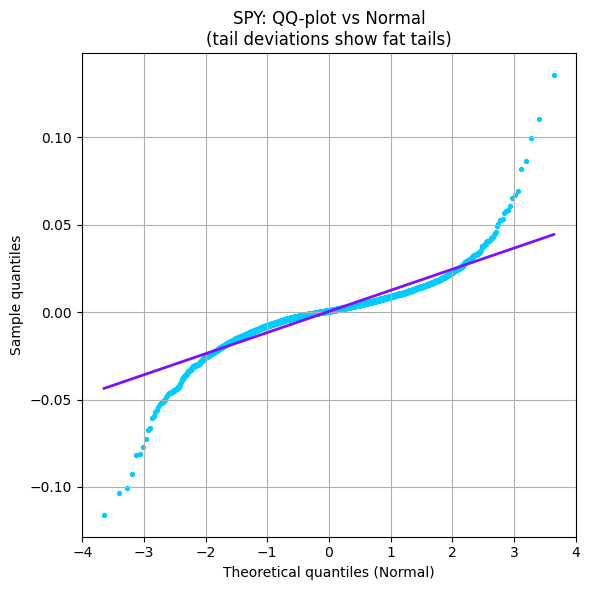

In [59]:
# --------------------
# 4) Fat tails: QQ-plot vs Normal
# --------------------

import numpy as np
from scipy import stats

# r is your pandas Series/DataFrame of returns
vals = np.asarray(r).astype(float).ravel()   # ensure 1-D float array

# summary stats (scalars, no warnings)
mu   = vals.mean()
sd   = vals.std(ddof=1)                      # sample std
kurt = stats.kurtosis(vals, fisher=False, nan_policy="omit")  # Pearson kurtosis
jb_stat, jb_p = stats.jarque_bera(vals)

print(f"Mean={mu:.6f}, Std={sd:.6f}, Kurtosis(Pearson)={kurt:.2f}")
print(f"Jarque–Bera: stat={jb_stat:.2f}, p-value={jb_p:.3e}")


# (theo_q, samp_q), (slope, intercept, r_) = stats.probplot(r.values, dist="norm")
(theo_q, samp_q), (slope, intercept, r_) = stats.probplot(vals, dist="norm", fit=True)

fig, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(theo_q, samp_q, color = ITMO_capri, s=8)
# 45-degree line based on sample mean & sd
line_x = np.linspace(min(theo_q), max(theo_q), 100)
ax.plot(line_x, mu + sd*line_x, color = ITMO_VIOLET, linewidth=2)   # reference line
ax.set_title(f"{TICKER}: QQ-plot vs Normal\n(tail deviations show fat tails)")
ax.set_xlabel("Theoretical quantiles (Normal)")
ax.set_ylabel("Sample quantiles")
ax.grid(True)
fig.tight_layout()
fig.savefig("figs/fat_tails_qq.pdf")
fig.savefig("figs/fat_tails_qq.png", dpi=200)

print("Saved figures to ./figs/: vol_clustering.*  fat_tails_hist.*  fat_tails_qq.*")


# Heston Model

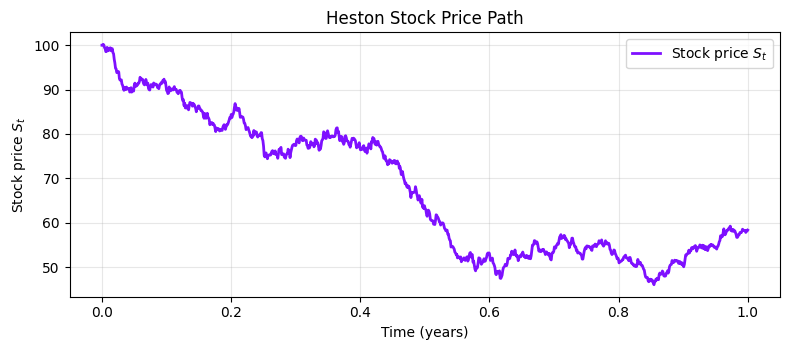

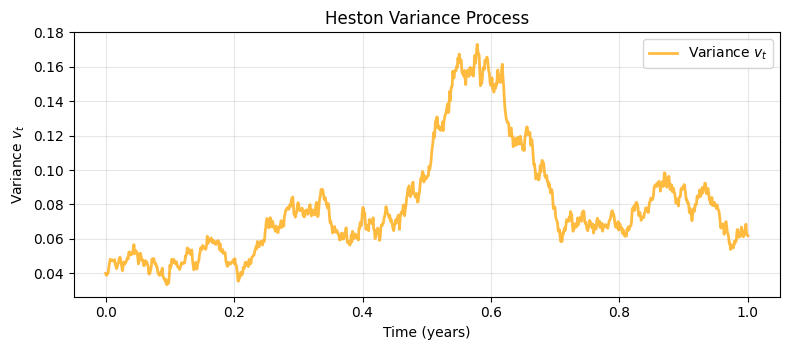

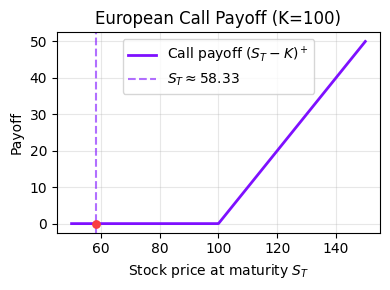

In [65]:
# ---------------- Colors (your palette) ----------------
ITMO_VIOLET = (126/255, 16/255, 1.0, 1.0)      # \definecolor{ITMOviolet}{RGB}{126,16,255}
CYAN        = (0/255, 191/255, 255/255, 0.6)   # rgba(0,191,255,0.6)
ORANGE      = (255/255, 165/255, 0/255, 0.75)  # rgba(255,165,0,0.75)
GREEN       = (0/255, 255/255, 0/255, 0.75)    # rgba(0,255,0,0.75)

ITMO_yellow = ( 1., 1., 0, 1. )
ITMO_green = ( 91/255, 1.0, 0., 1. ) 
ITMO_capri = ( 0., 204/255, 1., 1. )
ITMO_pink = ( 251/255, 118/255, 251/255, 1. )
ITMO_red = ( 249/255,63/255,65/255, 1. )

# ---------------- Heston parameters ----------------
S0    = 100.0   # Initial stock price
K     = 100.0   # Strike
r     = 0.05    # Risk-free rate
v0    = 0.04    # Initial variance
kappa = 2.0     # Mean reversion speed
theta = 0.04    # Long-run variance
xi    = 0.3     # Vol of variance
rho   = -0.7    # Corr(W1, W2)
T     = 1.0     # Maturity (years)
N     = 1000    # Time steps (points = N)

# Reproducibility
rng = np.random.default_rng(7)

# Time grid
t = np.linspace(0.0, T, N)
dt = T / (N - 1)  # N points -> N-1 intervals

# Correlated Brownian increments
dW1 = rng.normal(0.0, np.sqrt(dt), size=N-1)
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * rng.normal(0.0, np.sqrt(dt), size=N-1)

# Allocate
S = np.empty(N, dtype=float)
v = np.empty(N, dtype=float)
S[0] = S0
v[0] = v0

# Euler (full truncation) for Heston + exact step for S under Euler vol
for i in range(1, N):
    v_prev_pos = max(v[i-1], 0.0)
    # Variance step (full truncation)
    v[i] = v[i-1] + kappa * (theta - v_prev_pos) * dt + xi * np.sqrt(v_prev_pos) * dW2[i-1]
    v[i] = max(v[i], 0.0)
    # Stock step uses non-negative variance
    S[i] = S[i-1] * np.exp((r - 0.5 * v_prev_pos) * dt + np.sqrt(v_prev_pos) * dW1[i-1])

final_S = float(S[-1])
final_payoff = max(final_S - K, 0.0)

# Payoff curve for diagram
S_range = np.linspace(0.5 * S0, 1.5 * S0, 800)
payoff = np.maximum(S_range - K, 0.0)

# ---------------- Figure 1: Heston stock path ----------------
fig1, ax1 = plt.subplots(figsize=(8, 3.6))
ax1.plot(t, S, color=ITMO_VIOLET, linewidth=2.0, label="Stock price $S_t$")
ax1.set_title("Heston Stock Price Path")
ax1.set_xlabel("Time (years)")
ax1.set_ylabel(r"Stock price $S_t$")
ax1.grid(True, alpha=0.3)
ax1.legend()
fig1.tight_layout()
fig1.savefig("figs/heston_stock_path_ITMOviolet.pdf")
fig1.savefig("figs/heston_stock_path_ITMOviolet.png", dpi=300)

# ---------------- Figure 2: Variance process ----------------
fig2, ax2 = plt.subplots(figsize=(8, 3.6))
ax2.plot(t, v, color=ORANGE, linewidth=2.0, label="Variance $v_t$")
ax2.set_title("Heston Variance Process")
ax2.set_xlabel("Time (years)")
ax2.set_ylabel(r"Variance $v_t$")
ax2.grid(True, alpha=0.3)
ax2.legend()
fig2.tight_layout()
fig2.savefig("figs/heston_variance_orange.pdf")
fig2.savefig("figs/heston_variance_orange.png", dpi=300)

# ---------------- Figure 3: European call payoff ----------------
fig3, ax3 = plt.subplots(figsize=(4, 3))
ax3.plot(S_range, payoff, color=ITMO_VIOLET, linewidth=2.0, label=r"Call payoff $(S_T - K)^+$")
ax3.axvline(final_S, color=ITMO_VIOLET_60, linewidth=1.5, linestyle="--", label=rf"$S_T \approx {final_S:.2f}$")
ax3.scatter([final_S], [final_payoff], color=ITMO_red, s=28, zorder=3)
ax3.set_title(f"European Call Payoff (K={int(K)})")
ax3.set_xlabel(r"Stock price at maturity $S_T$")
ax3.set_ylabel("Payoff")
ax3.grid(True, alpha=0.3)
ax3.legend()
fig3.tight_layout()
fig3.savefig("figs/heston_call_payoff_green.pdf")
fig3.savefig("figs/heston_call_payoff_green.png", dpi=300)

plt.show()
